In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from scipy.special import expit  # Sigmoid function

def sigmoid_interpolation(start, end, steps):
    """
    Interpolates between start and end values using a sigmoid function over a specified number of steps.
    """
    x = np.linspace(-6, 6, steps)  # Range chosen to cover the significant transition of the sigmoid curve
    y = expit(x)  # Sigmoid function
    interpolated_values = start + (end - start) * y
    return interpolated_values

In [2]:
filename = "../data/sfo_weather_2023_2024.csv"
#data source
df = pd.read_csv(filename, delimiter=',')
keep = ['DATE', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'HourlyWindSpeed','HourlyWindDirection', 'HourlyPrecipitation']
df = df[keep]
df.ffill(inplace=True)
df['timestamp']=pd.to_datetime(df['DATE'], format='%Y-%m-%dT%H:%M:%S')
df.set_index(df['timestamp'], inplace=True)
df.drop(columns=['DATE'], inplace=True)
# Drop the 'STATION' column
df.drop(columns=['timestamp'], inplace=True)
# Convert object columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')
# Replace NaN values with ffill
df.ffill(inplace=True)
df = df.iloc[2:]



#normalize each column: 
df_normalized = df.copy()  # Create a copy of the original DataFrame
columns_to_normalize = ['HourlyDryBulbTemperature', 'HourlyVisibility', 'HourlyWindSpeed', 'HourlyWindDirection', 'HourlyPrecipitation']
for column in columns_to_normalize:
    df_normalized[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
df_normalized.tail()

/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_5435/4052528160.py:3: DtypeWarning: Columns (21,27,28,29,30,53,72,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, delimiter=',')


,HourlyDryBulbTemperature,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation
timestamp,,,,,
2024-06-21 21:56:00,0.235294,1.000,0.255814,0.833333,0.0
2024-06-21 22:00:00,0.235294,0.994,0.255814,0.833333,0.0
2024-06-21 22:56:00,0.235294,1.000,0.232558,0.861111,0.0
2024-06-21 23:56:00,0.235294,1.000,0.186047,0.861111,0.0
2024-06-21 23:59:00,0.235294,1.000,0.186047,0.861111,0.0


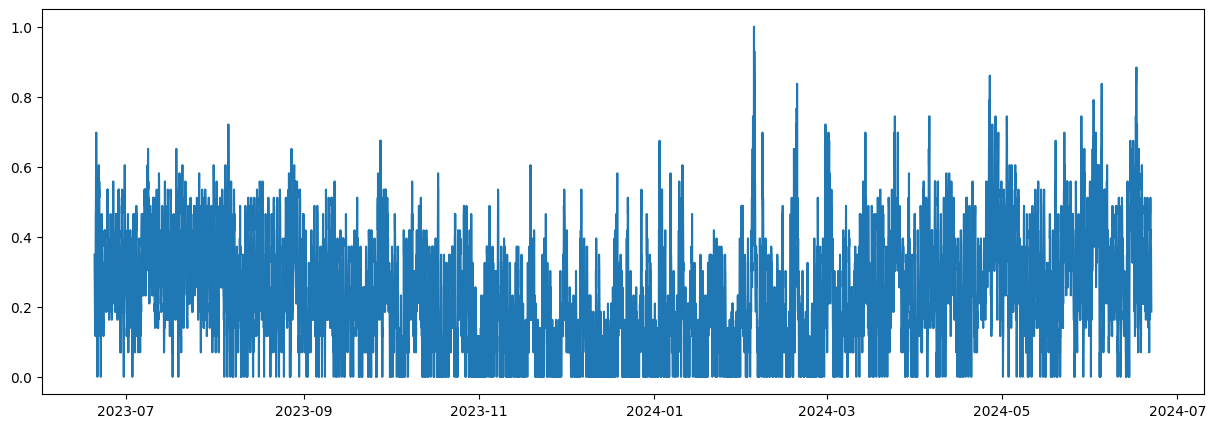

In [3]:
plt.figure(figsize =(15,5))
plt.plot(df_normalized.index, df_normalized["HourlyWindSpeed"])
plt.show()

In [4]:
df_normalized.shape

(12709, 5)

In [5]:
# Define the desired frequency for resampling
desired_freq = '30min'  # 30-minute intervals

# Initialize an empty DataFrame with an empty DatetimeIndex for holding interpolated data
interpolated_data = pd.DataFrame(index=pd.DatetimeIndex([]))


In [6]:
# Process each column separately
for column in df_normalized.columns:
    # Drop NaN values to work with actual data points
    data = df_normalized[column].dropna()

    # Create a new Series to hold the interpolated series
    interpolated_series = pd.Series(dtype=float)

    # Iterate over each pair of consecutive data points
    for i in range(len(data) - 1):
        start_time = data.index[i]
        end_time = data.index[i + 1]
        start_value = data.iloc[i]
        end_value = data.iloc[i + 1]

        # Generate timestamps between start and end at the desired frequency
        timestamps = pd.date_range(start=start_time, end=end_time, freq=desired_freq)[1:-1]

        # Perform sigmoid interpolation
        interpolated_values = sigmoid_interpolation(start_value, end_value, len(timestamps))

        # Create a temporary series with interpolated values
        temp_series = pd.Series(interpolated_values, index=timestamps)

        # Concatenate the temporary series to the interpolated series
        interpolated_series = pd.concat([interpolated_series, temp_series])

    # Combine with original data
    interpolated_series = pd.concat([interpolated_series, data])

    # Sort the index to maintain chronological order
    interpolated_series = interpolated_series.sort_index()

    # Add the interpolated series to the DataFrame after removing duplicates and reindexing
    interpolated_data[column] = interpolated_series


# Resample to consistent 30-minute intervals
interpolated_data = interpolated_data.resample(desired_freq).mean()


# Forward-fill any remaining NaN values
interpolated_data = interpolated_data.ffill()


# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

trimmed_data.tail()

/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_5435/1060359576.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_5435/1060359576.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_5435/1060359576.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. I

,HourlyDryBulbTemperature,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation
2024-06-20 18:30:00,0.254902,1.000,0.302326,0.750000,0.0
2024-06-20 19:00:00,0.254902,0.994,0.302326,0.750000,0.0
2024-06-20 19:30:00,0.254902,1.000,0.290698,0.736111,0.0
2024-06-20 20:00:00,0.254902,1.000,0.255756,0.722222,0.0
2024-06-20 20:30:00,0.254902,1.000,0.232558,0.722222,0.0


In [11]:
trimmed_data["HourlyWindSpeed_24row_mean"] = trimmed_data["HourlyWindSpeed"].rolling(window=12).mean()
trimmed_data["HourlyWindDirection_24row_mean"] = trimmed_data["HourlyWindDirection"].rolling(window=12).mean()
trimmed_data["HourlyDryBulbTemperature_6row_mean"] = trimmed_data["HourlyDryBulbTemperature"].rolling(window=6).mean()

/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_5435/2916318316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data["HourlyWindSpeed_24row_mean"] = trimmed_data["HourlyWindSpeed"].rolling(window=12).mean()
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_5435/2916318316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data["HourlyWindDirection_24row_mean"] = trimmed_data["HourlyWindDirection"].rolling(window=12).mean()
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000

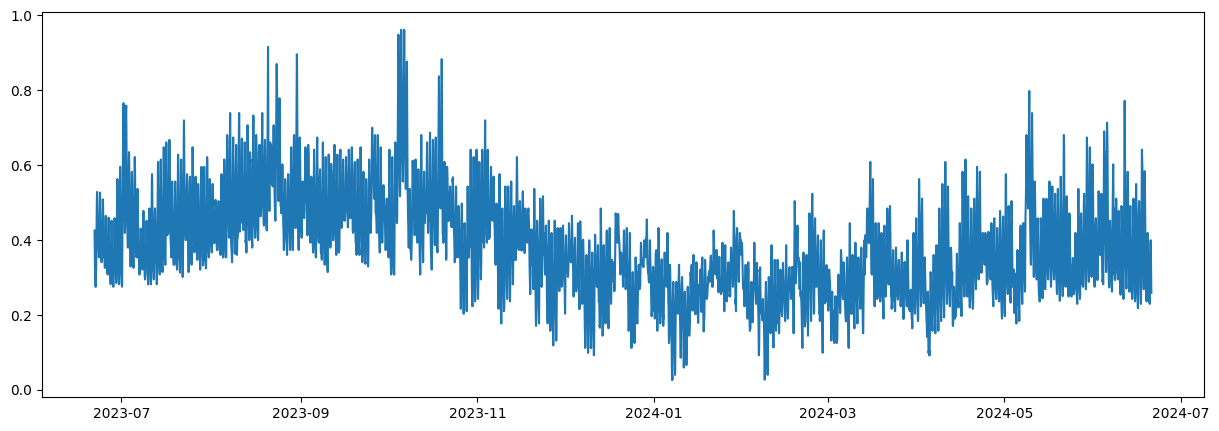

In [13]:
plt.figure(figsize =(15,5))
plt.plot(trimmed_data.index, trimmed_data["HourlyDryBulbTemperature_6row_mean"])
plt.show()

In [14]:
trimmed_data.to_csv('../data/SFO_weather.csv')

In [15]:
trimmed_data.shape

(17532, 9)